In [ ]:
from braindecode.datasets import TUHAbnormal

TUHAbnormal_PATH = '/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0'
N_JOBS = 8  # specify the number of jobs for loading and windowing


tuh = TUHAbnormal(
    path=TUHAbnormal_PATH,
    recording_ids=None,
    target_name=('report','pathological','gender','age'),
    preload=False,
    add_physician_reports=True,
    n_jobs=N_JOBS, 
)

In [5]:
print("length of dataset : ", len(tuh))

x, y = tuh[-1]
print('y:', y)

length of dataset :  1035794884
y: ['CLINICAL HISTORY:  A 21-year-old female with multiple concussions, most recently October 6, with headaches and intermittent difficulty with concentration.\nMEDICATIONS:  Elavil, albuterol, Naprosyn.\nINTRODUCTION:  Digital video EEG was performed in the lab using standard 10-20 system of electrode placement with 1 channel EKG.  Hyperventilation and photic stimulation were completed.  This is an awake and asleep record.  It is technically satisfactory with impedances under 5 kilohms.\nDESCRIPTION OF THE RECORD:  In wakefulness, there is a 10 Hz alpha rhythm which is symmetric and reactive to eye opening.  Alpha squeak was noted.  Brief drowsiness is characterized by an increase in beta, but sleep was not sustained.\nHyperventilation produced a small increase in amplitude of the background.  Photic stimulation elicited scant driving.\nHeart rate: 55 bpm.\nIMPRESSION:  Normal EEG in wakefulness and brief drowsiness.\nCLINICAL CORRELATION:  No focal or 

In [59]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:

tuh_subjects = tuh.split('subject')
key_list = list(tuh_subjects.keys())
report_df = pd.DataFrame(columns=('report', 'pathological', 'gender', 'age'))
for i in range(len(key_list)):
   report_df.loc[i] = tuh_subjects[key_list[i]][0][1]


report_embeddings = []
for r in report_df['report']:
        print(r)
        desc_tokenized = bert_tokenizer(r, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
        outputs = bert_model(**desc_tokenized)

        report_embeddings.append(outputs.to_tuple()[0][0][0].detach().numpy().tolist())

report_embeddings = np.array(report_embeddings)
report_df['report_embedding'] = report_embeddings.tolist()
"""
report_df.to_csv("report_df.csv")

"""

In [33]:
report_df = pd.read_csv("report_df.csv")

In [36]:
# convert the report embeddings from string to array
import copy
for r in range(len(report_df)):
    re = copy.copy(report_df['report_embedding'][r])
    # convert the string to array
    re = re.replace('[', '')
    re = re.replace(']', '')
    re = re.replace(',', '')
    re = re.split()
    re = [float(i) for i in re]
    report_df['report_embedding'][r] = re


/tmp/ipykernel_4147/3961539874.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_df['report_embedding'][r] = re


In [37]:
# new column detecting if the report contains the word "seizure" Must filter out "no seizure"
report_df['seizure'] = report_df['report'].str.contains('seizure', case=False)
report_df['seizure'] = report_df['seizure'] & ~report_df['report'].str.contains('no seizure', case=False)

# new column detecting if the report contains the word "epilep". Must filter out "no epilep"
report_df['epilep'] = report_df['report'].str.contains('epilep', case=False)
report_df['epilep'] = report_df['epilep'] & ~report_df['report'].str.contains('no epilep', case=False)
# medication list 
medication_list = ["keppra", "dilantin", "depakote"]
# new column detecting if the report contains one or more medications
report_df['medication'] = report_df['report'].str.contains('|'.join(medication_list), case=False)

In [54]:
# decode gender from embeddings using logistic regression
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

X = np.asarray(report_df["report_embedding"].values.tolist())
y = report_df["epilep"].values


model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2)
print("balance of classes in train set: ", np.mean(y_train))
print("balance of classes in test set: ", np.mean(y_test))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ", balanced_accuracy_score(y_test, y_pred))



balance of classes in train set:  0.5577026301663983
balance of classes in test set:  0.575107296137339
Accuracy:  0.7703527815468114


/home/tidiane/miniconda3/envs/nail_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
def sentence_embedder(sentence):
    desc_tokenized = bert_tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
    outputs = bert_model(**desc_tokenized)
    return outputs.to_tuple()[0][0][0].detach().numpy().tolist()


In [70]:
# using distance (cosine similarity) to classify reports





field = "medication"
s0 = "no medication was prescribed"
s1 = "medication was prescribed"

field = "epilep"
s0 = "no epilep activity was observed"
s1 = "epilep activity was observed"

field = "seizure"
s0 = "no seizure activity was observed"
s1 = "seizure activity was observed"

field = "pathological"
s0 = "Normal EEG"
s1 = "Abnormal EEG"



s0_embed = sentence_embedder(s0)
s1_embed = sentence_embedder(s1)

from scipy.spatial import distance
# classify each report as either s0 or s1
distance_classifier = []
for r in report_df['report_embedding']:
    d0 = distance.cosine(r, s0_embed)
    d1 = distance.cosine(r, s1_embed)
    if d0 < d1:
        distance_classifier.append(0)
    else:
        distance_classifier.append(1)

print("label balance :", np.mean(distance_classifier))

# compare to the actual labels
print("Accuracy: ", balanced_accuracy_score(report_df[field], distance_classifier))


label balance : 0.9497638471446973
Accuracy:  0.51550250710511


0.0

In [56]:
# decode age from embeddings using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#model = LinearRegression()

# using a mlp
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)


# using xgboost
import xgboost as xgb
#model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 5, alpha = 10, n_estimators = 10)

y = report_df["age"].values


X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
# average age error
print("MAE: ", np.mean(np.abs(y_test - y_pred)))

MSE:  268.11795243202226
MAE:  13.087494605749962


/home/tidiane/miniconda3/envs/nail_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


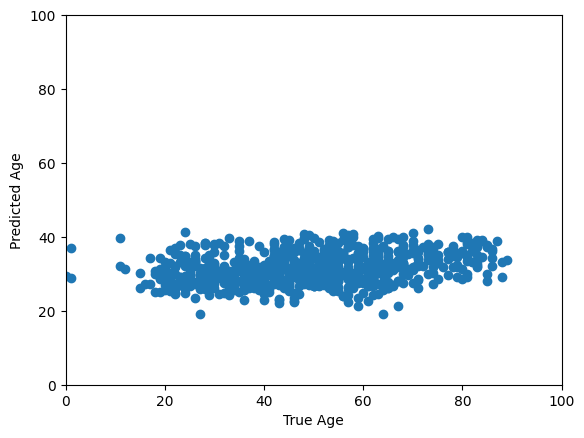

In [25]:
# plot predicted age vs. true age
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
# set xmin and xmax to the same value to make the plot square
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()